## Classificador Perceptron Simples com PCA

Semelhante à questão 1.2, essa implementação usa do Classificador Perceptron Simples, mas com uso de *Principal Component Analysis* (**PCA**), que é uma técnica de tranformação dos dados, preservando suas componentes principais e, portanto, reduzindo sua dimensionalidade [1].

### Sobre o dataset
A classificação foi feita para o *dataset* MNIST, de dígitos feitos à mão [2], que é composto por 60 mil imagens de treino e 10 mil imagens de teste. Todas elas são de dimensões 28x28 *pixels* e possuem suas respectivas classes (*labels*). O único pré-processamento utilizado foi a vetorização das imagens e a concatenação da matriz de imagens com um vetor de viés (*bias*), resultando em 785 atributos para a classificação. As *labels* também foram convertidas para o formato de vetor (*one hot*).

### Principal Component Analysis
Após a normalização dos dados da média pelo desvio-padrão é calculada a matriz de covariância dos dados, representada pela equação abaixo:

$$
C = \frac{X_n^T X_n}{n}
$$

onde **C** é a matriz de covariância, **$X_n$** é a matriz de dados normalizados e **n** a quantidade de dados [3].

Após o cálculo da matriz de covariância, são calculados os autovalores e autovetores daqueles dados, para então obtenção das componentes principais. Após isso, faz-se a tranformação dos dados, pelo produto escalar de **$X_n$** (matriz normalizada) pelo **$V_q$** (principais componentes), gerando uma nova matriz dos dados **Z**.

$$
Z = X_n V_q
$$

A matriz **Z** tem 235 atributos, ou seja, reduziu a dimensão original de 785 para 235, reduzindo cerca de 70% da dimensão original, e portanto tornando o treinamento muito mais rápido.

**Referências:**
1. R, Markus, "What is principal component analysis?". *Nature biotechnology*, v. 26, n. 3, p. 303-304, 2008.
2. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." *Proceedings of the IEEE*, 86(11):2278-2324, November 1998.
3. W. O. de Araujo and C. J. Coelho, “Análise de componentes principais (pca)”, *University Center of Anápolis*, Annapolis, 2009. 

7


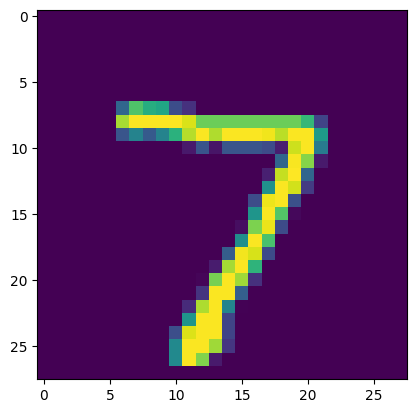

In [10]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

train_images_path = '../Datasets/MNIST/train-images.idx3-ubyte'
train_labels_path = '../Datasets/MNIST/train-labels.idx1-ubyte'
test_images_path = '../Datasets/MNIST/t10k-images.idx3-ubyte'
test_labels_path = '../Datasets/MNIST/t10k-labels.idx1-ubyte'

# Carregar o conjunto de treino para avaliação
arr_images_train = idx2numpy.convert_from_file(train_images_path)
arr_labels_train = idx2numpy.convert_from_file(train_labels_path).astype(int)

# Carregar o conjunto de teste para avaliação
arr_images_test = idx2numpy.convert_from_file(test_images_path)
arr_labels_test = idx2numpy.convert_from_file(test_labels_path).astype(int)

example = np.asarray(arr_images_test[0]).squeeze()
plt.imshow(example)

print(arr_labels_test[0])

In [11]:
print(arr_images_train.shape, arr_labels_train.shape)

(60000, 28, 28) (60000,)


In [12]:
# Transformar as imagens em vetores
X_train = arr_images_train.reshape(arr_images_train.shape[0], -1)
X_test = arr_images_test.reshape(arr_images_test.shape[0], -1)

# Adicionar uma coluna de 1s para considerar o termo de bias (intercept) no modelo linear
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test = np.column_stack((X_test, np.ones(X_test.shape[0])))

# Colocar y em formato de vetor (one hot)
def one_hot_convert(vec):
    matrix = []
    for idx in vec:
      m = np.zeros((10, 1))
      m[idx] = 1
      matrix.append(m)
    return np.array(matrix)

y_train = one_hot_convert(arr_labels_train).reshape(arr_labels_train.shape[0], -1)
y_test = arr_labels_test.reshape(arr_labels_test.shape[0], -1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 785) (60000, 10)
(10000, 785) (10000, 1)


In [13]:
# Função para definir a matriz de transformação
def pca_train(X, tol):
    n = X.shape[0]

    # Normalização dos dados
    std = np.std(X, axis=0)
    X_norm = (X - np.mean(X, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero

    # Matriz de covariância
    Cx = (X_norm.T @ X_norm) / n
    
    eigenvalues, eigenvectors = np.linalg.eig(Cx)
    
    idxs = eigenvalues.argsort()[::-1] # Índices do maior para o menor
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idxs] # Montagem de autovetores

    var = np.cumsum(eigenvalues) / np.sum(eigenvalues) # variancia explicada

    num_components = np.sum(var <= tol) # Num. compon. principais

    Vq = eigenvectors[:, :num_components] # Matriz com q primeiros autovetores

    return Vq

# Função para aplicar a transformação nos dados
def pca_transform(Vq, X):
    # Normalização dos dados
    std = np.std(X, axis=0)
    X_norm = (X - np.mean(X, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    
    Z = X_norm @ Vq # Transformação
    
    return Z

Vq = pca_train(X_train, 0.9)
print(Vq.shape)

(785, 235)


In [14]:
X_train = pca_transform(Vq, X_train)
X_test = pca_transform(Vq, X_test)

print(X_train.shape, X_test.shape)

(60000, 235) (10000, 235)


In [15]:
# Funções de ativação para o neurônio
def activate_functions(type, matrix):
    if type == 'sigmoid':
        return 1 / (1 + np.exp(-matrix))
    elif type == 'softmax':
        exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        return exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)   
    elif type == 'tanh':
        return np.tanh(matrix)
    elif type == 'step':
        return np.heaviside(matrix, 1)

# Função de treino para o classificador perceptron logístico
def train_logistic_perceptron(X, y, epochs, l_rate):
    weights = np.random.randn(y.shape[1], X.shape[1]) * 0.1 # Matriz com dimensões: num_classes X num_atributos
    
    for epoch in range(epochs): # Iterando épocas
        
        z = X @ weights.T
        result = activate_functions('softmax', z)
        error =  result - y # Erro por classe
        grad = error / len(X)

        # Ajustar os pesos para cada classe separadamente
        weights -= l_rate * np.dot(grad.T, X)

        if epoch % 5 == 0:
            print('Epoch: {}/{}'.format(epoch, epochs))
            
    print('Done!')
    
    return weights

# Treinar o classificador
weights = train_logistic_perceptron(X_train, y_train, epochs=500, l_rate=0.01)
print(weights.shape)

Epoch: 0/500
Epoch: 5/500
Epoch: 10/500
Epoch: 15/500
Epoch: 20/500
Epoch: 25/500
Epoch: 30/500
Epoch: 35/500
Epoch: 40/500
Epoch: 45/500
Epoch: 50/500
Epoch: 55/500
Epoch: 60/500
Epoch: 65/500
Epoch: 70/500
Epoch: 75/500
Epoch: 80/500
Epoch: 85/500
Epoch: 90/500
Epoch: 95/500
Epoch: 100/500
Epoch: 105/500
Epoch: 110/500
Epoch: 115/500
Epoch: 120/500
Epoch: 125/500
Epoch: 130/500
Epoch: 135/500
Epoch: 140/500
Epoch: 145/500
Epoch: 150/500
Epoch: 155/500
Epoch: 160/500
Epoch: 165/500
Epoch: 170/500
Epoch: 175/500
Epoch: 180/500
Epoch: 185/500
Epoch: 190/500
Epoch: 195/500
Epoch: 200/500
Epoch: 205/500
Epoch: 210/500
Epoch: 215/500
Epoch: 220/500
Epoch: 225/500
Epoch: 230/500
Epoch: 235/500
Epoch: 240/500
Epoch: 245/500
Epoch: 250/500
Epoch: 255/500
Epoch: 260/500
Epoch: 265/500
Epoch: 270/500
Epoch: 275/500
Epoch: 280/500
Epoch: 285/500
Epoch: 290/500
Epoch: 295/500
Epoch: 300/500
Epoch: 305/500
Epoch: 310/500
Epoch: 315/500
Epoch: 320/500
Epoch: 325/500
Epoch: 330/500
Epoch: 335/500
Ep

In [16]:
# Função de predição usando o classificador linear
def predict_logistic_perceptron(X, W):
    z = X @ weights.T
    result = activate_functions('softmax', z)

    # Converte as saídas para as classes preditas (0 a 9) usando a função argmax
    # A classe predita será o índice do valor máximo em cada linha
    classe = np.argmax(result, axis=1)
    print(classe.shape)

    return np.expand_dims(classe, axis=1)

# Realizar a predição no conjunto de teste
y_pred_test = predict_logistic_perceptron(X_test, weights)

print(y_pred_test.shape)
print(y_test.shape)

(10000,)
(10000, 1)
(10000, 1)


In [17]:
# Avaliar o desempenho do classificador
error = (10000 - sum(y_pred_test == y_test)) / 10000 
print("Error: {}".format(error[0]))
print("Accuracy: {}".format(1 - error[0]))

Error: 0.1366
Accuracy: 0.8634
